In [1]:
%load_ext dotenv
%dotenv -o

import os
os.environ["POLYGON_DATA_DIR"]

'/media/mirror/files.polygon.io'

In [24]:
from zipline_polygon_bundle.config import PolygonConfig
from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
from zipline_polygon_bundle import get_custom_aggs_dates
from zipline_polygon_bundle import get_ticker_universe

from typing import Iterator, Tuple
import warnings

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import compute as pc
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [3]:
if not "POLYGON_TICKERS_DIR" in os.environ:
    os.environ["POLYGON_TICKERS_DIR"]= "/home/jovyan/data/tickers"

if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/data"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2018-01-01",
    end_date="2023-12-31",
    agg_time="1min",
)

pd.set_option('display.width', 250)

print(f"{config.minute_aggs_dir=}")
print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
print(f"{config.aggs_dir=}")
print(f"{config.by_ticker_dir=}")

config.minute_aggs_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/minute_aggs_v1'
config.trades_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/trades_v1'
config.custom_aggs_dir='/home/jovyan/data/60sec_aggs'
config.aggs_dir='/home/jovyan/data/60sec_aggs'
config.by_ticker_dir='/home/jovyan/data/60sec_aggs_by_ticker'


In [4]:
ticker_universe = get_ticker_universe(config, fetch_missing=True)
ticker_universe

tickers_csv_path='/home/jovyan/data/tickers/tickers_2018-01-01_2023-12-31.csv'
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49789 entries, ('CpP', 'XNYS', '0000831001', 'PFD', nan, True) to ('ZZrw', 'XNYS', '0000748015', 'RIGHT', nan, False)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_date        49789 non-null  datetime64[ns]
 1   end_date          49789 non-null  datetime64[ns]
 2   last_updated_utc  49789 non-null  object        
 3   name              49789 non-null  object        
 4   share_class_figi  49789 non-null  object        
 5   delisted_utc      49789 non-null  object        
 6   currency_name     49789 non-null  object        
 7   locale            49789 non-null  object        
 8   market            49789 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.3+ MB


,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
CpP,XNYS,0000831001,PFD,NaN,True,2018-01-02,2018-01-02,2024-12-03,[Citigroup Inc],[],[],[usd],[us],[stocks]
XKII,ARCX,0001081019,NaN,BBG00JHNY9Z4,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Intelligent Structures ETF],[BBG00JHNYBP0],[],[usd],[us],[stocks]
XKST,ARCX,0001081019,NaN,BBG00JHP5PG6,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Smart Mobility ETF],[BBG00JHP5Q56],[],[usd],[us],[stocks]
LDRS,ARCX,0001415726,NaN,UNKNOWN,True,2018-01-02,2018-01-02,2024-12-03,[Innovator IBD� ETF Leaders ETF],[UNKNOWN],[],[usd],[us],[stocks]
XKFS,ARCX,0001081019,NaN,BBG00JHP6203,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Future Security ETF],[BBG00JHP62Q5],[],[usd],[us],[stocks]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOEV,XNAS,0001750153,CS,BBG00NBK0GC3,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Class A Common Stock],[BBG00NBK0H68],[],[usd],[us],[stocks]
GOEVW,XNAS,0001750153,WARRANT,BBG00NWRF3R2,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Warrant],[],[],[usd],[us],[stocks]
GOEX,ARCX,0001432353,ETF,BBG0018HBWX2,True,2018-01-02,2023-12-29,2024-12-03,[Global X Gold Explorers ETF (NEW)],[BBG001TF8DG8],[],[usd],[us],[stocks]


In [5]:
ticker_universe[ticker_universe.index.get_level_values('ticker').str.contains("TEST")].sort_index()

,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
ATEST,XASE,0001415311,NaN,BBG000Q2HK03,False,2018-01-02,2023-12-29,2016-10-25,[None],[BBG001S6X7W6],[2016-10-25],[usd],[us],[stocks]
ATEST.A,XASE,NaN,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.B,XASE,0000849998,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.C,XASE,0000860188,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST,XNYS,0001515980,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.A,XNYS,0001566897,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.B,XNYS,0000807884,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.C,XNYS,0000805264,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]


In [6]:
valid_tickers = pa.array([ticker for ticker in ticker_universe.index.get_level_values('ticker').to_list() if "TEST" not in ticker])
len(valid_tickers)

49781

In [4]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


# def label_ticker_day_aggs(df: pd.DataFrame, sessions: pd.Series):
#     pre_df = label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
#     market_df = label_ticker_session(df, start=sessions['market_open'], end=sessions['market_close'] - pd.Timedelta(seconds=60))
#     post_df = label_ticker_session(df, start=sessions['market_close'], end=sessions['post'] - pd.Timedelta(seconds=60))
#     return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(sessions, aggs_df):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        return label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
    
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_df = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_df.info()
    print(labeled_aggs_df)
    return labeled_aggs_df


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            labeled_aggs_dfs.append(label_custom_aggs_for_date(sessions, fragment.to_table().to_pandas()))

    return labeled_aggs_dfs

In [5]:
def label_ticker_session(df: pd.DataFrame):
    # df.info()
    df = df.set_index('window_start').sort_index()
    open_price = df.iloc[0]['price']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['price'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_custom_aggs_for_date(df: pd.DataFrame):
    # df.set_index('ticker', inplace=True)
    # df.sort_index(inplace=True)
    # df = df.set_index('ticker').sort_index()
    return df.set_index('ticker').sort_index().groupby('ticker').apply(label_ticker_session)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post")
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        # print(f"{date=} {sessions=}")
        start_dt = sessions['pre']
        end_dt = sessions['market_open']
        print(f"{date=} {start_dt=} {end_dt=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        date_filter_expr = ((pc.field('year') == date.year)
                       & (pc.field('month') == date.month)
                       & (pc.field('date') == date.to_pydatetime().date()))
        print(f"{date_filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=date_filter_expr):
            session_filter = ((pc.field('window_start') >= start_dt)
                              & (pc.field('window_start') < end_dt))
            # Sorting table doesn't seem to avoid needing to sort the df.  Maybe use_threads=False on to_pandas would help?
            # table = fragment.to_table(filter=session_filter).sort_by([('ticker', 'ascending'), ('window_start', 'descending')])
            table = fragment.to_table(filter=session_filter)
            # TODO: Compute VWAP in the trades to aggs conversion.
            table = table.append_column("price",
                                        pc.divide(
                                            pc.add(table.column("open"),
                                                   pc.add(table.column("close"),
                                                          pc.add(table.column("high"), table.column("low")))),
                                            4))
            labeled_aggs_dfs.append(label_custom_aggs_for_date(table.to_pandas()))

    return labeled_aggs_dfs

In [36]:
%%time

config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
labeled_aggs_dfs = label_custom_aggs_ds(config)
labeled_aggs_dfs

date=Timestamp('2024-12-05 00:00:00') start_dt=Timestamp('2024-12-05 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-05 14:30:00+0000', tz='UTC')
date_filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
CPU times: user 10.5 s, sys: 42.5 ms, total: 10.5 s
Wall time: 10.5 s


[                                    open    high     low   close  volume  transactions   price  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
 ticker                                                                                                                                                            
 A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19     4.0           2.0  140.17        0.000000          140.15            140.19      NaN      NaN
        2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-

In [37]:
len(labeled_aggs_dfs)

1

In [38]:
labeled_aggs_dfs[0].info()
labeled_aggs_dfs[0]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   volume            159913 non-null  float64
 5   transactions      159913 non-null  float64
 6   price             159913 non-null  float64
 7   gain_from_open    159913 non-null  float64
 8   fwd_1h_min_low    933044 non-null  float64
 9   fwd_1h_max_close  933044 non-null  float64
 10  gain_1h           153782 non-null  float64
 11  loss_1h           153782 non-null  float64
dtypes: float64(12)
memory usage: 108.5+ MB


open    high     low   close  volume  transactions   price  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
ticker                                                                                                                                                            
A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19     4.0           2.0  140.17        0.000000          140.15            140.19      NaN      NaN
       2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:36:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN             NaN               NaN      NaN      NaN
...                                  ...     ...     ...     ...     ...           ...     ...             ...             ...               ...      ...      ...
ZYXI   2024-12-05 14:25:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:26:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:27:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:28:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN     NaN             NaN            8.05              8.05      0.0      0.0
       2024-12-05 14:29:00+00:00    8.05    8.05    8.05    8.05     8.0           1.0    8.05        0.124378            8.05              8.05      NaN      NaN

[1135582 rows x 12 columns]

In [39]:
labeled_aggs_dfs[0].index.get_level_values(1).min(), labeled_aggs_dfs[0].index.get_level_values(1).max()

(Timestamp('2024-12-05 09:00:00+0000', tz='UTC'),
 Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))

In [58]:
 aggs_df.index.get_level_values(0).unique()

Index(['AACT.WS', 'AAME', 'ABL', 'ABVC', 'ACES', 'ACRpD', 'ACTU', 'ACWX', 'ADC', 'ADEA',
       ...
       'ZH', 'ZIONP', 'ZIP', 'ZLAB', 'ZTEK', 'ZURA', 'ZVOL', 'ZVRA', 'ZWS', 'ZYME'], dtype='object', name='ticker', length=1164)

In [59]:
aggs_df = labeled_aggs_dfs[0]
tickers = aggs_df.index.get_level_values(0).unique()
for ticker in tickers:
    if ticker.startswith('RK'):
        print(ticker)

In [42]:
# ticker = "AA"
ticker = "RKDA"
# ticker = "AAPL"
aggs_df = labeled_aggs_dfs[0]
aggs_df.info()
ticker_df = aggs_df.loc[(ticker)]
show(ticker_df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   volume            159913 non-null  float64
 5   transactions      159913 non-null  float64
 6   price             159913 non-null  float64
 7   gain_from_open    159913 non-null  float64
 8   fwd_1h_min_low    933044 non-null  float64
 9   fwd_1h_max_close  933044 non-null  float64
 10  gain_1h           153782 non-null  float64
 11  loss_1h           153782 non-null  float64
dtypes: float64(12)
memory usage: 108.5+ MB


In [43]:
ticker_df

,open,high,low,close,volume,transactions,price,gain_from_open,fwd_1h_min_low,fwd_1h_max_close,gain_1h,loss_1h
2024-12-05 13:02:00+00:00,2.81,4.09,2.79,3.49,8556.0,125.0,3.2950,0.000000,2.79,9.23,97.644540,-40.256959
2024-12-05 13:03:00+00:00,3.49,4.95,3.29,4.67,104406.0,1095.0,4.1000,24.430956,3.29,9.23,68.430657,-39.963504
2024-12-05 13:04:00+00:00,4.64,6.24,4.64,5.48,264580.0,3007.0,5.2500,59.332322,4.52,9.23,71.561338,-15.985130
2024-12-05 13:05:00+00:00,5.50,5.80,5.01,5.38,175500.0,2462.0,5.4225,64.567527,4.52,9.23,79.223301,-12.233010
2024-12-05 13:06:00+00:00,5.40,5.40,4.74,5.15,161050.0,1679.0,5.1725,56.980273,4.52,9.23,89.139344,-7.377049
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 14:25:00+00:00,7.42,7.62,7.40,7.62,13963.0,232.0,7.5150,128.072838,6.90,7.62,3.673469,-6.122449
2024-12-05 14:26:00+00:00,7.61,7.62,7.35,7.35,33790.0,402.0,7.4825,127.086495,6.90,7.35,0.547196,-5.608755
2024-12-05 14:27:00+00:00,7.41,7.46,7.16,7.31,31322.0,455.0,7.3350,122.610015,6.90,7.31,0.412088,-5.219780
2024-12-05 14:28:00+00:00,7.30,7.39,7.25,7.28,16918.0,202.0,7.3050,121.699545,6.90,7.28,3.116147,-2.266289


In [62]:
prices = ticker_df["price"].values 
diffs = np.diff(prices)
change_points = np.where(diffs < 0)
change_points[0]

array([ 3,  4,  5, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 26, 31, 32, 33,
       34, 35, 36, 37, 38, 41, 42, 51, 52, 56, 57, 58, 59, 60, 61, 64, 65,
       67, 68, 72, 73, 74, 75, 76, 79, 80, 81, 83, 84, 85, 86])

In [85]:
def find_monotonic_runs(group):
    prices = group['price'].values
    diffs = np.diff(prices)
    change_points = np.where(diffs < 0)[0] + 1
    
    # Add start and end points
    change_points = np.concatenate(([0], change_points, [len(prices)]))
    
    runs = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i + 1] - 1
        if end_idx >= start_idx + 3:
            start_price = prices[start_idx]
            end_price = prices[end_idx]
            gain = 100 * (end_price - start_price) / start_price
            # print(f"{gain=}")
            # print(f"{start=} {ticker_df.loc[start]['price']=}")
            # print(f"{end=} {ticker_df.loc[end]['price']=}")
            runs.append({"gain": gain,
                         "duration": end_idx - start_idx,
                         "start_price": start_price,
                         "end_price": end_price,
                         "start": group.index[start_idx],
                         "end": group.index[end_idx]})
    
    return pd.DataFrame(runs)

In [86]:
find_monotonic_runs(ticker_df)

,gain,duration,start_price,end_price,start,end
0,64.567527,3,3.2950,5.4225,2024-12-05 13:02:00+00:00,2024-12-05 13:05:00+00:00
1,52.261048,6,4.8650,7.4075,2024-12-05 13:08:00+00:00,2024-12-05 13:14:00+00:00
2,11.610352,4,6.9550,7.7625,2024-12-05 13:29:00+00:00,2024-12-05 13:33:00+00:00
3,21.925134,8,7.0125,8.5500,2024-12-05 13:45:00+00:00,2024-12-05 13:53:00+00:00
4,6.997608,3,8.3600,8.9450,2024-12-05 13:55:00+00:00,2024-12-05 13:58:00+00:00
5,2.080099,3,8.0525,8.2200,2024-12-05 14:11:00+00:00,2024-12-05 14:14:00+00:00


In [155]:
29//10

2

In [30]:
def find_price_runs(df: pd.DataFrame):
    df = df.set_index('window_start').sort_index()
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)    
    prices = df['vwap'].values
    diffs = np.diff(prices)
    change_points = np.where(diffs < 0)[0] + 1
    
    # Add start and end points
    change_points = np.concatenate(([0], change_points, [len(prices)]))
    
    runs = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i + 1] - 1
        if end_idx >= start_idx + 3:
            start_price = prices[start_idx]
            end_price = prices[end_idx]
            gain = 100 * (end_price - start_price) / start_price
            if (gain > 25) & (start_price > 0.5):
                # TODO: Return up to ten prices and resample if longer to fit.
                start_dt = df.index[start_idx]
                end_dt = df.index[end_idx]
                price_series = df.loc[start_dt:end_dt]['vwap']
                volume_series = df.loc[start_dt:end_dt]["volume"]
                volume = volume_series.sum()
                traded_value = (price_series * volume_series).sum()
                if traded_value > 100000:
                    previous_price = prices[start_idx-1] if (start_idx > 0) else None
                    next_price = prices[end_idx+1] if (end_idx + 1 < len(prices)) else None
                    if len(price_series) > 10:
                        price_series = price_series.iloc[::(len(price_series) // 10)]
                    runs.append({"gain": gain,
                                 "duration": end_idx - start_idx,
                                 "volume": volume,
                                 "traded_value": traded_value,
                                 "start_dt": start_dt,
                                 "end_dt": end_dt,
                                 "previous_price": previous_price,
                                 "start_price": start_price,
                                 "end_price": end_price,
                                 "next_price": next_price,
                                 "prices": price_series.to_list()
                                })
    if len(runs):
        return pd.DataFrame(runs).set_index("start_dt").sort_index()
    return None


def label_price_runs_by_ticker(df: pd.DataFrame):
    # Ignoring this warning from the groupby call.
    # Tried suggested fixes but haven't figured out one that works.
    # FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. 
    # In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes.
    # To retain the old behavior, exclude the relevant entries before the concat operation.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        return df.set_index('ticker').sort_index().groupby(level=0).apply(find_price_runs, include_groups=False)

def label_price_runs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post")
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        # print(f"{date=} {sessions=}")
        start_dt = sessions['pre']
        end_dt = sessions['market_open']
        print(f"{date=} {start_dt=} {end_dt=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        date_filter_expr = ((pc.field('year') == date.year)
                       & (pc.field('month') == date.month)
                       & (pc.field('date') == date.to_pydatetime().date()))
        # print(f"{date_filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=date_filter_expr):
            session_filter = ((pc.field('window_start') >= start_dt) 
                              & (pc.field('window_start') < end_dt) 
                              & pc.is_in(pc.field('ticker'), valid_tickers)
                             )
            # Sorting table doesn't seem to avoid needing to sort the df.  Maybe use_threads=False on to_pandas would help?
            # table = fragment.to_table(filter=session_filter).sort_by([('ticker', 'ascending'), ('window_start', 'descending')])
            table = fragment.to_table(filter=session_filter)
            if (table.num_rows > 0):
                labeled_aggs_dfs.append(label_price_runs_by_ticker(table.to_pandas()))

    return pd.concat(labeled_aggs_dfs)

In [31]:
%%time

config.start_date = '2024-12-01'
config.end_date = '2024-12-07'
price_run_dfs = label_price_runs_ds(config)
show(price_run_dfs)

date=Timestamp('2024-12-02 00:00:00') start_dt=Timestamp('2024-12-02 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-02 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-03 00:00:00') start_dt=Timestamp('2024-12-03 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-03 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-04 00:00:00') start_dt=Timestamp('2024-12-04 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-04 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-05 00:00:00') start_dt=Timestamp('2024-12-05 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-05 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-06 00:00:00') start_dt=Timestamp('2024-12-06 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-06 14:30:00+0000', tz='UTC')


CPU times: user 12.9 s, sys: 154 ms, total: 13.1 s
Wall time: 12.9 s


In [32]:
price_run_dfs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 55 entries, ('PPBT', Timestamp('2024-12-02 09:10:00+0000', tz='UTC')) to ('UPC', Timestamp('2024-12-06 09:53:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   gain            55 non-null     float64            
 1   duration        55 non-null     int64              
 2   volume          55 non-null     float64            
 3   traded_value    55 non-null     float64            
 4   end_dt          55 non-null     datetime64[ns, UTC]
 5   previous_price  46 non-null     float64            
 6   start_price     55 non-null     float64            
 7   end_price       55 non-null     float64            
 8   next_price      55 non-null     float64            
 9   prices          55 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(1)
memory usage: 323.5+ KB


In [33]:
pd.set_option('display.precision', 2)

In [ ]:
%%time

config.start_date = '2022-9-01'
config.end_date = '2022-12-31'
runs_df = label_price_runs_ds(config)
show(runs_df)

date=Timestamp('2022-09-01 00:00:00') start_dt=Timestamp('2022-09-01 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-01 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-02 00:00:00') start_dt=Timestamp('2022-09-02 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-02 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-06 00:00:00') start_dt=Timestamp('2022-09-06 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-06 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-07 00:00:00') start_dt=Timestamp('2022-09-07 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-07 13:30:00+0000', tz='UTC')


In [62]:
show(runs_df[runs_df["prices"].apply(lambda p: not(any(pd.isna(x) for x in p[1:-2])))])

In [7]:
gapless_runs_df = runs_df[runs_df["prices"].apply(lambda p: not(any(pd.isna(x) for x in p[1:-2])))]
gapless_runs_df

gain  duration    volume  traded_value                    end_dt  start_price  end_price                                             prices
ticker start_dt                                                                                                                                                                   
BGXX   2022-09-01 08:01:00+00:00  69.897031         5  186545.0  3.922370e+05 2022-09-01 08:06:00+00:00     1.429889   2.429338    [1.43, 1.43, 1.52, 1.65, 2.0, 2.31, 2.43, 2.12]
       2022-09-01 08:08:00+00:00  48.405127         6  532067.0  1.319684e+06 2022-09-01 08:14:00+00:00     2.018262   2.995205  [2.12, 2.02, 2.16, 2.22, 2.24, 2.31, 2.46, 3.0...
HPCO   2022-09-01 09:53:00+00:00  31.175384         7   36762.0  2.654253e+05 2022-09-01 10:00:00+00:00     5.879275   7.712162  [5.93, 5.88, 5.95, 6.04, 6.27, 6.61, 7.01, 7.6...
SHPH   2022-09-01 08:25:00+00:00  41.934480         6    8005.0  4.826509e+05 2022-09-01 08:31:00+00:00    48.558235  68.920879  [48.63, 48.56, 48.75, 50.58, 51.46, 53.72, 60....
       2022-09-01 11:59:00+00:00  28.654660         5   34730.0  2.677851e+06 2022-09-01 12:04:00+00:00    65.582882  84.375434  [66.09, 65.58, 66.53, 66.8, 70.85, 78.67, 84.3...
...                                     ...       ...       ...           ...                       ...          ...        ...                                                ...
OP     2022-12-22 12:04:00+00:00  25.162708         4   90725.0  1.996372e+05 2022-12-22 12:08:00+00:00     1.870006   2.340551          [1.9, 1.87, 1.94, 2.02, 2.19, 2.34, 2.33]
PALI   2022-12-30 11:55:00+00:00  36.176336        14  690326.0  3.323120e+06 2022-12-30 12:09:00+00:00     3.909246   5.323467  [3.95, 3.91, 3.94, 3.95, 3.98, 4.08, 4.11, 4.2...
SILO   2022-12-30 13:16:00+00:00  31.474622         4  441112.0  2.750435e+06 2022-12-30 13:20:00+00:00     5.212806   6.853518          [5.24, 5.21, 5.67, 6.3, 6.44, 6.85, 6.73]
TUEM   2022-12-30 10:21:00+00:00  27.583987         4   99959.0  1.153719e+05 2022-12-30 10:25:00+00:00     0.953417   1.216408          [1.02, 0.95, 1.01, 1.07, 1.2, 1.22, 1.13]
       2022-12-30 10:26:00+00:00  31.521600         4  133102.0  1.737807e+05 2022-12-30 10:30:00+00:00     1.126175   1.481163         [1.22, 1.13, 1.22, 1.23, 1.24, 1.48, 1.48]

[103 rows x 8 columns]

In [11]:
show(gapless_runs_df[gapless_runs_df["duration"] > 4])

In [40]:
runs_df.iloc[0]

gain                                                  74.731183
duration                                                      5
volume                                                 186545.0
traded_value                                        394933.3875
end_dt                                2022-09-01 08:06:00+00:00
start_price                                               1.395
end_price                                                2.4375
prices          [1.43, 1.4, 1.53, 1.66, 2.03, 2.32, 2.44, 2.21]
Name: (BGXX, 2022-09-01 08:01:00+00:00), dtype: object

In [52]:
runs_df.index.get_level_values(0).to_list()

['BGXX',
 'BGXX',
 'HPCO',
 'PXMD',
 'SHPH',
 'SHPH',
 'SHPH',
 'SXTC',
 'BGXX',
 'CMCM',
 'DRUG',
 'USEA',
 'SIDU',
 'TLF',
 'BGXX',
 'IFBD',
 'IFBD',
 'MTEST.A',
 'NRBO',
 'BIAF',
 'CLBS',
 'NRBO',
 'SPRC',
 'BEAT',
 'HKD',
 'LSTA',
 'LSTA',
 'AMPX',
 'AMPX',
 'BCAN',
 'BCAN',
 'BCAN',
 'FOXO',
 'FOXO',
 'FOXO',
 'HOLO',
 'SNTI',
 'BCAN',
 'EVAX',
 'BEAT',
 'PRST',
 'SPRO',
 'RUBY',
 'SONX',
 'SONX',
 'CTEST.A',
 'LVTX',
 'RDHL',
 'ARDS',
 'AMV',
 'SILO',
 'SILO',
 'SOBR',
 'TOPS',
 'ALPS',
 'BBAI',
 'MOTS',
 'SHFS',
 'AIMD',
 'SHFS',
 'SNTI',
 'SPRC',
 'ATXI',
 'CLNN',
 'LOGC',
 'XOS',
 'MTC',
 'KITT',
 'ANVS',
 'GGE',
 'ADTX',
 'LUCY',
 'LUCY',
 'NVIV',
 'SCPH',
 'SNTI',
 'AMV',
 'DICE',
 'VOXR',
 'HPCO',
 'AGFY',
 'INPX',
 'LFG',
 'VEV',
 'AGFY',
 'LMAO',
 'RDHL',
 'SILO',
 'MOTS',
 'TCDA',
 'TCDA',
 'NUVL',
 'SLNA',
 'ABMD',
 'PKBO',
 'SNTG',
 'DWAC',
 'SPRC',
 'VERU',
 'ICCM',
 'MTEST.A',
 'MACK',
 'MSGM',
 'UHAL',
 'GSUN',
 'PDSB',
 'RDHL',
 'SBFM',
 'CTMX',
 'HTOO',
 'ENSC',
 

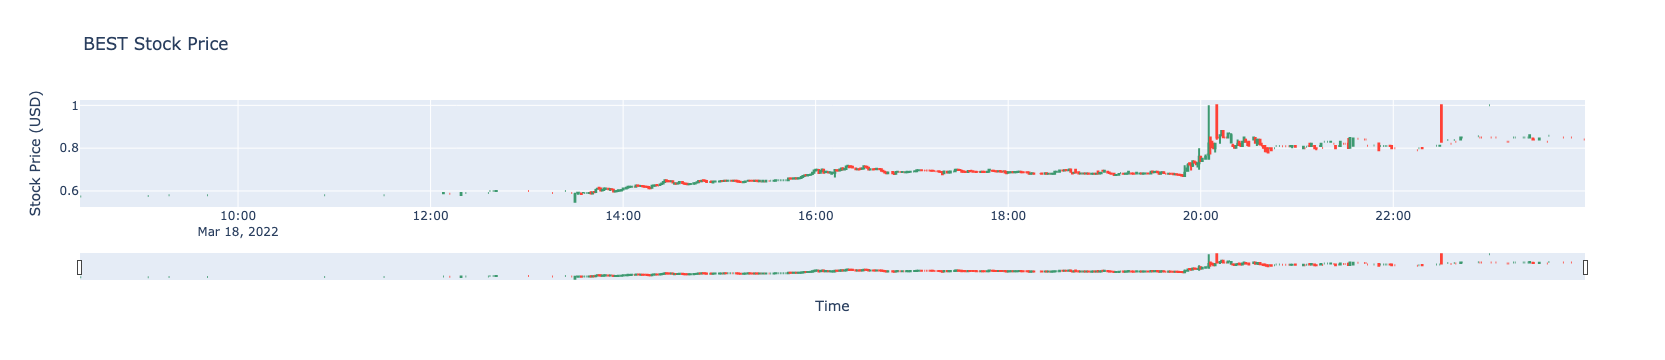

In [42]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [ ]:
# This was run including the TRF trades.  The notable difference is ignoring the the $1.0 trade reported at 21:05 but which took place earlier. The bars at 20:05, 20:10, and 22:30 seem related.
# https://polygon.io/blog/understanding-trade-eligibility

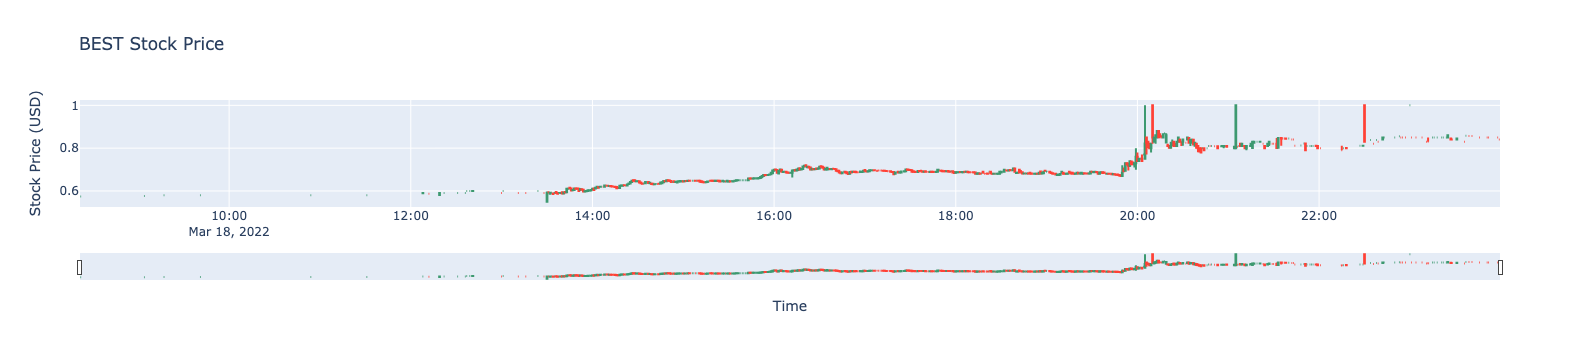

In [39]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [236]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_ticker_day_aggs(df: pd.DataFrame, schedule: pd.Series):
    pre_df = label_ticker_session(df, start=schedule['pre'], end=schedule['market_open'] - pd.Timedelta(seconds=60))
    market_df = label_ticker_session(df, start=schedule['market_open'], end=schedule['market_close'] - pd.Timedelta(seconds=60))
    post_df = label_ticker_session(df, start=schedule['market_close'], end=schedule['post'] - pd.Timedelta(seconds=60))
    return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(date, sessions, fragment):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        df = label_ticker_day_aggs(df, sessions)
        # df['ticker'] = ticker
        return df
    
    aggs_table = fragment.to_table()
    aggs_df = aggs_table.to_pandas()
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_dfs = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_dfs.info()
    print(labeled_aggs_dfs)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            label_custom_aggs_for_date(date, sessions, fragment)

In [238]:
config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
label_custom_aggs_ds(config)

date=Timestamp('2024-12-05 00:00:00') sessions=pre            2024-12-05 04:00:00-05:00
market_open    2024-12-05 09:30:00-05:00
market_close   2024-12-05 16:00:00-05:00
post           2024-12-05 20:00:00-05:00
Name: 2024-12-05 00:00:00, dtype: datetime64[ns, US/Eastern]
filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6425354 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZZZ', Timestamp('2024-12-05 21:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   open              float64
 1   high              float64
 2   low               float64
 3   close             float64
 4   volume            float64
 5   transactions      float64
 6   gain_from_open    float64
 7   fwd_1h_min_low    float64
 8   fwd_1h_max_close  float64
 9   gain_1h           float64
 10  loss_1h           float64
dtypes: